# **Project: Amazon Product Recommendation System**

# **Marks: 60**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model. 

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business. 

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predictin g customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:** 
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions. 

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

**Installing surprise library**

In [ ]:
#!pip install surprise

## **Importing the necessary libraries and overview of the dataset**

In [1]:
import numpy as np                              # Basic libraries for numeric and dataframe
import pandas as pd

import matplotlib.pyplot as plt                 # Visualization libraries
import seaborn as sns                           # Slightly advanced library for data visualization

from sklearn.metrics import mean_squared_error  # A performance metrics in sklearn
from collections import defaultdict             # A dictionary output that does not raise a key error

import warnings                                 # Used to ignore the warning
warnings.filterwarnings('ignore')

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [2]:
df = pd.read_csv('ratings_Electronics.csv', header=None)
df.head()

,0,1,2,3
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [3]:
# header = None does not provide header column names. Here set descriptive names to mantain the code cleaner.
df.columns = ['user_id', 'prod_id', 'rating', 'timestamp'] # Adding column names
df.head()

,user_id,prod_id,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [4]:
#timestamp is not needed for the current analysis. It could be used if we want to consider the latest rating for a given product.
df = df.drop('timestamp', axis = 1)
df.head()

,user_id,prod_id,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


In [5]:
#save a copy in case we need to rest the DataFrame and to avoid the import time.
df_copy=df.copy(deep = True)

In [6]:
#Check the full number of rows and columns.
df.shape

(7824482, 3)

**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product. 

In [7]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:        
        ratings_count[user] += 1
  
    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [8]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [9]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:
    
    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1
    
    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1    

In [10]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [11]:
# df_final is our processed data which will be used for the rest of the analysis.
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


In [12]:
#Check the number of rows and columns for df_final.
df_final.shape

(65290, 3)

## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [14]:
# Check the number of rows and columns and provide observations
orows, ocolumns = df_copy.shape
rows, columns = df_final.shape
print("original number of rows and columns:", (orows, ocolumns))
print("final number of rows and columns:", (rows, columns))

original number of rows and columns: (7824482, 3)
final number of rows and columns: (65290, 3)


**Observations**
- Taking products with at least 50 rankings and users that have given at least 5 ratings to be conisder for our final data to be used for recommendation.
- We manged to reduce from 7,824,482 observations to only 65,290, that is, less than 1% (0.83%) of the original data.

### **Data types**

In [15]:
# Check Data types and provide observations
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65290 entries, 1310 to 7824427
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


**Observations**

- Both userid and prod_id are string values. Although the prod_id look like integers by just showing a few records, the fact that it was imported as an object, reflects that some product ids may contain characters.
- rating is already of type float. This indicates that all entries were interpreted as numeric.


### **Checking for missing values**

In [16]:
# Check for missing values present and provide observations
df_final.nunique()

user_id    1540
prod_id    5689
rating        5
dtype: int64

In [17]:
df_final.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
user_id,65290,1540,ADLVFFE4VBT8,295,NaN,NaN,NaN,NaN,NaN,NaN,NaN
prod_id,65290,5689,B0088CJT4U,206,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rating,65290.0,NaN,NaN,NaN,4.294808,0.988915,1.0,4.0,5.0,5.0,5.0


In [18]:
df_final[['user_id','prod_id']].nunique()

user_id    1540
prod_id    5689
dtype: int64

In [19]:
df_final[['user_id','prod_id']].count()

user_id    65290
prod_id    65290
dtype: int64

In [20]:
df_final['user_id'].value_counts()

ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
                 ... 
A16CVJUQOB6GIB      2
A2BGZ52M908MJY      2
A3DL29NLZ7SXXG      1
AP2NZAALUQKF5       1
A3MV1KKHX51FYT      1
Name: user_id, Length: 1540, dtype: int64

In [21]:
df_final['prod_id'].value_counts()

B0088CJT4U    206
B003ES5ZUU    184
B000N99BBC    167
B007WTAJTO    164
B00829TIEK    149
             ... 
B00368CDH6      5
B0036AZA6A      5
B0036E8V08      5
B0036QL1JY      5
B00LGQ6HL8      5
Name: prod_id, Length: 5689, dtype: int64

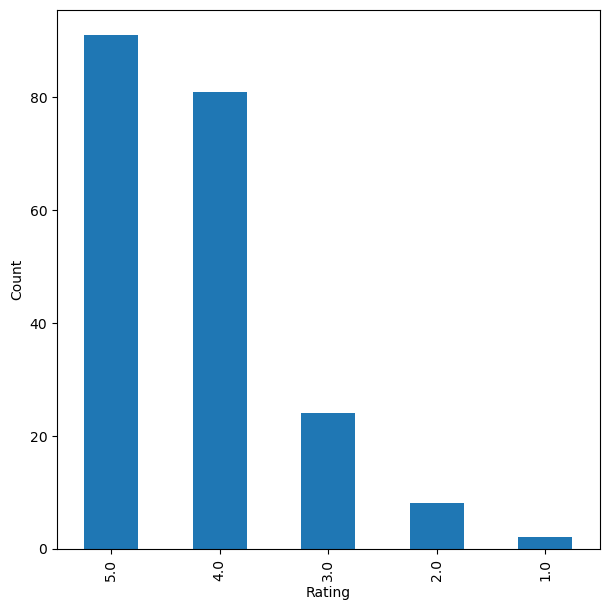

In [51]:
# Plotting distributions of ratings for the most rated product

plt.figure(figsize=(7,7))

df_final[df_final['prod_id'] == 'B0088CJT4U']['rating'].value_counts().plot(kind='bar')

plt.xlabel('Rating')

plt.ylabel('Count')
plt.show()

In [53]:
# Finding user-product interactions distribution
count_interactions = df_final.groupby('user_id').count()['prod_id']
count_interactions

user_id
A100UD67AHFODS     53
A100WO06OQR8BQ     77
A105S56ODHGJEK     58
A105TOJ6LTVMBG     32
A10AFVU66A79Y1     47
                 ... 
AZBXKUH4AIW3X      22
AZCE11PSTCH1L      23
AZMY6E8B52L2T     105
AZNUHQSHZHSUE      30
AZOK5STV85FBJ      14
Name: prod_id, Length: 1540, dtype: int64

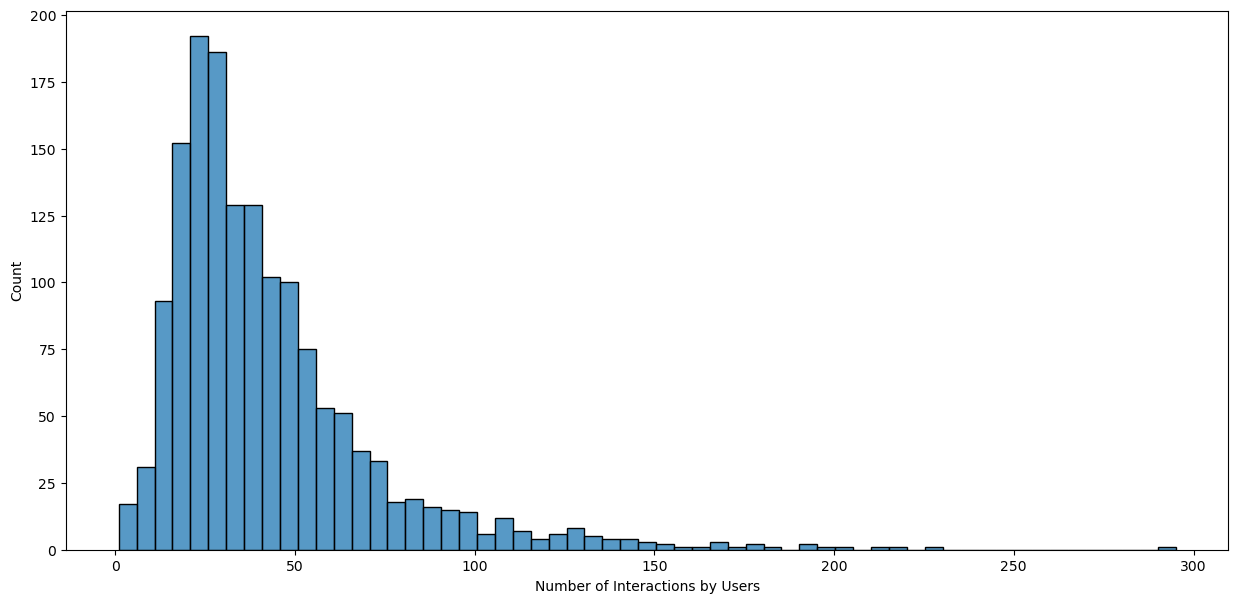

In [54]:
# Plotting user-item interactions distribution

plt.figure(figsize=(15,7))

sns.histplot(count_interactions)

plt.xlabel('Number of Interactions by Users')

plt.show()

**Observations**

- We have 1540 unique users and 5689 unique products.
- We see that product B0088CJT4U is the most rated one with 206 ratings. Most of the ratings, apprx 170, for this product are 4 and 5.
- The user ADLVFFE4VBT8 has given close to 300 (295) rated products.
- The user-product distribution is right skewed. We see that the bulk of ratings are given by around 50~60 users.

### **Summary Statistics**

In [22]:
# Summary statistics of 'rating' variable and provide observations
df_final['rating'].value_counts()

5.0    36315
4.0    18127
3.0     6481
2.0     2515
1.0     1852
Name: rating, dtype: int64

In [23]:
df_final['rating'].value_counts(normalize=True)

5.0    0.556211
4.0    0.277638
3.0    0.099265
2.0    0.038520
1.0    0.028366
Name: rating, dtype: float64

**Observations**

- 55% products have teh highest rating of 5
- We see that more than 80% are rated between 4 and 5 and only 20% have lower ratings.

### **Checking the rating distribution**

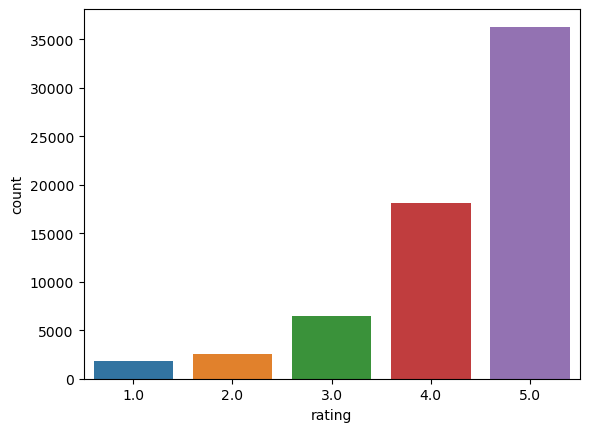

In [24]:
# Create the bar plot and provide observations
# Let's use sns in this case

sns.countplot(data=df_final, x='rating');

**Observations**
- We see that we around 35K ratings of 5 and 20K rating of 4.
- Only around 2K 1 ratings.

### **Checking the number of unique users and items in the dataset**

In [25]:
# Number of total rows in the data and number of unique user id and product id in the data
flen, userid_unique, prodid_unique = (len(df_final), df_final['user_id'].nunique(), df_final['prod_id'].nunique())
print('Total number of recors:', flen)
print('Number of unique user_ids:', userid_unique)
print('Number of unique produc_ids', prodid_unique)

Total number of recors: 65290
Number of unique user_ids: 1540
Number of unique produc_ids 5689


**Observations**
- We have **5689 products** in the data set.
- Since we have **1540 unique users**, we have a **possibility of 1540x5689=8,761,060 ratings** in the data set. But we **only have 65,290 ratings**.
- Not every use user has rated every product, so we can build a recommendation system to recommend products to users that have not purchased/interacted with other products.

### **Users with the most number of ratings**

In [29]:
df_final.groupby(['user_id', 'prod_id']).count()

rating
user_id        prod_id           
A100UD67AHFODS B00004Z5M1       1
               B0001D3K8A       1
               B000233WJ6       1
               B0002KVQBA       1
               B0002SQ2P2       1
...                           ...
AZOK5STV85FBJ  B005PQTYHE       1
               B006MPRFJQ       1
               B00AANMVNQ       1
               B00B25P27S       1
               B00FB2XNCE       1

[65290 rows x 1 columns]

In [30]:
df_final.groupby(['user_id', 'prod_id']).count()['rating'].sum()

65290

**Observation**

- The sum is equal to the total number of records, this implies that there is only one rating between a product and a user.

In [31]:
# Top 10 users based on the number of ratings
serie_user_ratings=df_final.groupby('user_id').size()
serie_user_ratings

user_id
A100UD67AHFODS     53
A100WO06OQR8BQ     77
A105S56ODHGJEK     58
A105TOJ6LTVMBG     32
A10AFVU66A79Y1     47
                 ... 
AZBXKUH4AIW3X      22
AZCE11PSTCH1L      23
AZMY6E8B52L2T     105
AZNUHQSHZHSUE      30
AZOK5STV85FBJ      14
Length: 1540, dtype: int64

In [32]:
serie_user_ratings.sort_values(ascending=False)[:15]

user_id
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A22CW0ZHY3NJH8    193
A1UQBFCERIP7VJ    193
AWPODHOB4GFWL     184
A3LGT6UZL99IW1    179
AGVWTYW0ULXHT     179
A23GFTVIETX7DS    173
A3AYSYSLHU26U9    169
A3EXWV8FNSSFL6    167
A3A4ZAIBQWKOZS    166
dtype: int64

In [33]:
top10_mostrated = serie_user_ratings.sort_values(ascending=False)[:10]
top10_mostrated

user_id
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A22CW0ZHY3NJH8    193
A1UQBFCERIP7VJ    193
AWPODHOB4GFWL     184
A3LGT6UZL99IW1    179
dtype: int64

**Observations**

- The highest number of ratings given by a user is 295. We have 5689 - 295 = 5394 products that can be recommended to this user.

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [34]:
# Calculate the average rating for each product 
mean_rating = df_final.groupby('prod_id').mean()['rating']
mean_rating

prod_id
1400501466    3.333333
1400532655    3.833333
1400599997    4.000000
9983891212    4.875000
B00000DM9W    5.000000
                ...   
B00L21HC7A    4.625000
B00L2442H0    4.916667
B00L26YDA4    4.384615
B00L3YHF6O    5.000000
B00LGQ6HL8    5.000000
Name: rating, Length: 5689, dtype: float64

In [35]:
# Calculate the count of ratings for each product
count_rating = df_final.groupby('prod_id').count()['rating']
count_rating

prod_id
1400501466     6
1400532655     6
1400599997     5
9983891212     8
B00000DM9W     5
              ..
B00L21HC7A    16
B00L2442H0    12
B00L26YDA4    13
B00L3YHF6O    14
B00LGQ6HL8     5
Name: rating, Length: 5689, dtype: int64

In [36]:
# Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'avg_rating':mean_rating, 'count_rating':count_rating})
final_rating.head()

,avg_rating,count_rating
prod_id,,
1400501466,3.333333,6
1400532655,3.833333,6
1400599997,4.000000,5
9983891212,4.875000,8
B00000DM9W,5.000000,5


In [37]:
# Sort the dataframe by average of ratings in the descending order
final_rating=final_rating.sort_values(by = 'avg_rating', ascending = False)
# See the first five records of the "final_rating" dataset
final_rating.head(5)

,avg_rating,count_rating
prod_id,,
B00LGQ6HL8,5.0,5
B003DZJQQI,5.0,14
B005FDXF2C,5.0,7
B00I6CVPVC,5.0,7
B00B9KOCYA,5.0,8


In [38]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions

def top_n_products(data, n, min_interactions):
    recommendations = data[data['count_rating'] > min_interactions] # find products with minimun number of interactions
    recommendations = recommendations.sort_values(by = 'avg_rating', ascending = False) # sort with respect to avergage rating
    return recommendations.index[:n]

### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [39]:
list(top_n_products(final_rating, 5, 50))

['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']

### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [40]:
list(top_n_products(final_rating, 5, 100))

['B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B002V88HFE', 'B004CLYEDC']

We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [41]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them. 

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [256]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)
    
    # Making predictions on the test data
    predictions = model.test(testset)
    
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    
    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)
    
    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)
    
    accuracy.rmse(predictions)
    
    print('Precision: ', precision) # Command to print the overall precision
    
    print('Recall: ', recall) # Command to print the overall recall

    F_1 =  round((2*precision*recall)/(precision+recall), 3) # Formula to compute the F-1 score
    
    print('F_1 score: ', F_1) 

    return [accuracy.rmse(predictions), precision, recall, F_1]

def Add_to_Model_Stats(model_stats, column_name, data):
    if type(model_stats)==int:
        return pd.DataFrame({'Model Stats': ['RMSE','Precision','Recall','F_1'], column_name: data})
    else:
        model_stats[column_name] = data
        return model_stats

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [43]:
# Just recall what df_final looks like
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


In [44]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale = (0,5))

In [45]:
# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

In [46]:
# Splitting the data into train (80%)  and test datasets, rest 20%
trainset, testset = train_test_split(data, test_size=0.2, random_state=1)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [58]:
# Declaring the similarity options
sim_options = {'name': 'cosine', 'user_based': True}

In [59]:
# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1

sim_knn_user = KNNBasic(sim_options = sim_options, verbose = False, random_state = 42)

In [60]:
# Fit the model on the training data

sim_knn_user.fit(trainset)

In [210]:
# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above

pr_at_k = precision_recall_at_k(sim_knn_user);

RMSE: 1.0260
Precision:  0.844
Recall:  0.862
F_1 score:  0.853
RMSE: 1.0260


In [211]:
model_stats = Add_to_Model_Stats(0, 'Similarity KNN User-User', pr_at_k)
model_stats

,Model Stats,Similarity KNN User-User
0,RMSE,1.026002
1,Precision,0.844000
2,Recall,0.862000
3,F_1,0.853000


**Observations**
- We can observe that tha bse line model has RMSE=1.0260 on the test set.
- We get a ** recall of ~0.862**, which means out of **all the relevant products, ~86% are recommended**.
- We get **precision of ~0.844**, which means **out of all then recomended books, 84% are relevant**.
- The **F_1 score** of the base model is ~.853**. This indicates thet **mostly recommended products were relevant and relevan products are recommended**.

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [73]:
#Verify that in effect user A3LDPF5FMB782Z has given a rating of 5 for product 1400501466
df_final[df_final['user_id']=='A3LDPF5FMB782Z'].sort_values(by='prod_id')

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
504686,A3LDPF5FMB782Z,B0002SQ0A4,4.0
675474,A3LDPF5FMB782Z,B0009O6IXA,1.0
1017085,A3LDPF5FMB782Z,B000HZDF8W,3.0
1047368,A3LDPF5FMB782Z,B000IF4788,5.0
1210521,A3LDPF5FMB782Z,B000NK8EWI,4.0
1295976,A3LDPF5FMB782Z,B000Q3043Y,5.0
1312372,A3LDPF5FMB782Z,B000QUUFRW,5.0
1714755,A3LDPF5FMB782Z,B0015DNIOG,4.0
1968967,A3LDPF5FMB782Z,B001EM9JXC,5.0


In [255]:
# Predictin g rating for a sample user with an interacted product
sim_knn_user.predict('A3LDPF5FMB782Z', '1400501466', r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.33   {'actual_k': 6, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.3333333333333335, details={'actual_k': 6, 'was_impossible': False})

**Observation**

- We observe that the actual rating for this user-product is 5 and a predicted 3.33 by this method. That looks low, that means that similar users have ranked the same product at a lower rate. Also, this indicates that we are not overfitting.

Below is the function to find the **list of users who have not seen the product with product id "1400501466"**.

In [63]:
def n_users_not_interacted_with(n, data, prod_id):
    users_interacted_with_product = set(data[data['prod_id'] == prod_id]['user_id'])
    all_users = set(data['user_id'])
    return list(all_users.difference(users_interacted_with_product))[:n] # where n is the number of elements to get in the list

In [70]:
# Find unique user_id where prod_id is not equal to "1400501466"
n_users_not_interacted_with(5, df_final, '1400501466')

['A1KD8NJPZ01R37',
 'A204K1OFE8OB9Y',
 'A1D9V11QUHXENQ',
 'A2QAOP52OEB5EV',
 'A3V7D0LH8L7BG0']

In [71]:
df_final[df_final['user_id']=='A1KD8NJPZ01R37'].sort_values(by='prod_id')

,user_id,prod_id,rating
26113,A1KD8NJPZ01R37,B00001W0DI,4.0
189309,A1KD8NJPZ01R37,B00006HZ0L,5.0
333247,A1KD8NJPZ01R37,B0000C0XS0,5.0
420605,A1KD8NJPZ01R37,B00021XIJW,1.0
722585,A1KD8NJPZ01R37,B000AP05BO,4.0
872381,A1KD8NJPZ01R37,B000EPHR0C,5.0
1319612,A1KD8NJPZ01R37,B000R2PC2M,3.0
1772871,A1KD8NJPZ01R37,B0017HF3XO,5.0
1986276,A1KD8NJPZ01R37,B001F0RPGG,5.0
2528154,A1KD8NJPZ01R37,B002BW6DBU,1.0


**Observation**

- In the original notebook, we were asked to check for user A2UOHALGF2X77Q which was suposed to have no interactions with product 1400501466 based on the result from function n_users_not_interacted_with. Since we did not get that user in the list, we will use user A1KD8NJPZ01R37 for the rest of the report.

* It can be observed from the above list that **user "A1KD8NJPZ01R37" has not seen the product with productId "1400501466"** as this user id is a part of the above list.

**Below we are predicting rating for `userId=A1KD8NJPZ01R37` and `prod_id=1400501466`.** 

In [72]:
# Predicting rating for a sample user with a non interacted product
sim_knn_user.predict("A1KD8NJPZ01R37", "1400501466", verbose = True)

user: A1KD8NJPZ01R37 item: 1400501466 r_ui = None   est = 4.30   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A1KD8NJPZ01R37', iid='1400501466', r_ui=None, est=4.296427477408486, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Observations**

- The predicted rating for this product that the user has not interacted with before is 4.29, that means it is likely that the user will like this product.

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise - 
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [74]:
# Setting up parameter grid to tune the hyperparameters

param_grid = {'k': [20, 30, 40], 
              'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }

In [76]:
# Performing 3-fold cross-validation to tune the hyperparameters

grid_obj = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

In [77]:
# Fitting the data

grid_obj.fit(data)

In [78]:
# Best RMSE score

grid_obj.best_score['rmse']

0.9717547573813059

In [79]:
# Combination of parameters that gave the best RMSE score

grid_obj.best_params['rmse']

{'k': 30, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}

Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [80]:
# Using the optimal similarity measure for user-user based collaborative filtering

sim_options = {'name': 'cosine', 'user_based': True}

In [81]:
# Creating an instance of KNNBasic with optimal hyperparameter values

sim_knn_user_optimized = KNNBasic(sim_options = sim_options, k =40, min_k = 6, random_state = 1, verbose = False)

In [82]:
# Training the algorithm on the trainset

sim_knn_user_optimized.fit(trainset)

In [212]:
# Let us compute precision@k and recall@k also with k =10

pr_at_k = precision_recall_at_k(sim_knn_user_optimized);

RMSE: 0.9759
Precision:  0.834
Recall:  0.896
F_1 score:  0.864
RMSE: 0.9759


In [213]:
model_stats = Add_to_Model_Stats(model_stats, 'Similarity KNN User Optimized', pr_at_k)
model_stats

,Model Stats,Similarity KNN User-User,Similarity KNN User Optimized
0,RMSE,1.026002,0.975863
1,Precision,0.844000,0.834000
2,Recall,0.862000,0.896000
3,F_1,0.853000,0.864000


**Observations**

- After running hyperparameters tunning, RMSE for the test set has reduced from 1.026 to 0.976
- But now the F_1 score increased from 0.853 to 0.864. We can say that the model's perfomance has improved.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A2UOHALGF2X77Q"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [128]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
sim_knn_user_optimized.predict('A3LDPF5FMB782Z', '1400501466', r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.33   {'actual_k': 6, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.3333333333333335, details={'actual_k': 6, 'was_impossible': False})

In [129]:
# Use sim_user_user_optimized model to recommend for userId "A1KD8NJPZ01R37" and productId "1400501466"
sim_knn_user_optimized.predict("A1KD8NJPZ01R37", "1400501466", verbose = True)

user: A1KD8NJPZ01R37 item: 1400501466 r_ui = None   est = 4.30   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A1KD8NJPZ01R37', iid='1400501466', r_ui=None, est=4.296427477408486, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [130]:
# compare with base model, not optimized
sim_knn_user.predict("A1KD8NJPZ01R37", "1400501466", verbose = True)

user: A1KD8NJPZ01R37 item: 1400501466 r_ui = None   est = 4.30   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A1KD8NJPZ01R37', iid='1400501466', r_ui=None, est=4.296427477408486, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Observations**

- For user A3LDPF5FMB782Z which had given a rating of 5, this model predicts a rating of 3.3
- User A1KD8NJPZ01R37 that has not interacted with this product, a 4.3 rating is predicted.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [132]:
# 0 is the inner id of the above user
sim_knn_user_optimized.get_neighbors(0, 5)

[1, 10, 17, 18, 28]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [133]:
def get_recommendations(data, user_id, top_n, algo):
    
    # Creating an empty list to store the recommended product ids
    recommendations = []
    
    # Creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')
    
    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:
        
        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est
        
        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [134]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df_final, 'A3LDPF5FMB782Z', 5, sim_knn_user_optimized)

In [135]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,B000067RT6,5
1,B001TH7GUU,5
2,B001UI2FPE,5
3,B001V9KG0I,5
4,B00316263Y,5


### **Correcting the ratings and ranking**

Let's Compute the corrected ratings based on the count_rating

In [136]:
#recall what final_rating looks like 
final_rating

,avg_rating,count_rating
prod_id,,
B00LGQ6HL8,5.000000,5
B003DZJQQI,5.000000,14
B005FDXF2C,5.000000,7
B00I6CVPVC,5.000000,7
B00B9KOCYA,5.000000,8
...,...,...
B003O2RVGM,1.833333,12
B000ND75C0,1.833333,6
B007C0Y7RI,1.625000,8


In [137]:
def ranking_products(recommendations, final_rating):
  # Sort the books based on ratings count
  ranked_prod = final_rating.loc[[items[0] for items in recommendations]].sort_values('count_rating', ascending=False)[['count_rating']].reset_index()

  # Merge with the recommended books to get predicted ratings
  ranked_prod = ranked_prod.merge(pd.DataFrame(recommendations, columns=['prod_id', 'predicted_ratings']), on='prod_id', how='inner')

  # Rank the books based on corrected ratings
  ranked_prod['corrected_ratings'] = ranked_prod['predicted_ratings'] - 1 / np.sqrt(ranked_prod['count_rating'])

  # Sort the books based on corrected ratings
  ranked_prod = ranked_prod.sort_values('corrected_ratings', ascending=False)
  
  return ranked_prod

In [138]:
# Corrected rating taking into account he number of ratings the product is given
ranking_products(recommendations, final_rating)

,prod_id,count_rating,predicted_ratings,corrected_ratings
0,B001TH7GUU,78,5,4.886772
1,B000067RT6,41,5,4.843826
2,B00316263Y,38,5,4.837779
3,B001UI2FPE,30,5,4.817426
4,B001V9KG0I,24,5,4.795876


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**. 

In [139]:
# Declaring the similarity options

sim_options = {'name': 'cosine', 'user_base': False}

In [140]:
# KNN algorithm is used to find desired similar items. Use random_state=1

sim_knn_item = KNNBasic(sim_option = sim_options, verbose = False, random_state = 1)

In [141]:
# Train the algorithm on the trainset, and predict ratings for the test set

sim_knn_item.fit(trainset)

In [214]:
# Let us compute precision@k, recall@k, and f_1 score with k = 10

pr_at_k = precision_recall_at_k(sim_knn_item);
model_stats = Add_to_Model_Stats(model_stats, 'Similarity KNN Item-Item', pr_at_k)
model_stats

RMSE: 1.0322
Precision:  0.845
Recall:  0.859
F_1 score:  0.852
RMSE: 1.0322


,Model Stats,Similarity KNN User-User,Similarity KNN User Optimized,Similarity KNN Item-Item
0,RMSE,1.026002,0.975863,1.032217
1,Precision,0.844000,0.834000,0.845000
2,Recall,0.862000,0.896000,0.859000
3,F_1,0.853000,0.864000,0.852000


**Observations:**

- This model has RMSE = 1.032 and F_1 0.852 in the test set
- The precision value is slightly better in this model, but not for recall and F_1

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [215]:
# Predicting rating for a sample user with an interacted product
sim_knn_item.predict('A3LDPF5FMB782Z', '1400501466', r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.74   {'actual_k': 6, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.73758865248227, details={'actual_k': 6, 'was_impossible': False})

In [216]:
# Recall the predicted value from the user based model
sim_knn_user_optimized.predict('A3LDPF5FMB782Z', '1400501466', r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.33   {'actual_k': 6, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.3333333333333335, details={'actual_k': 6, 'was_impossible': False})

**Observations**

- We get an estimated 4.74 which is closer to the observed 5. This is a better estimate than the one predicted using the user base model which was given a 3.33 value

Below we are **predicting rating for the `userId = A1KD8NJPZ01R37` and `prod_id = 1400501466`**.

In [217]:
# Predicting rating for a sample user with a non interacted product
sim_knn_item.predict('A1KD8NJPZ01R37', '1400501466', verbose = True)

user: A1KD8NJPZ01R37 item: 1400501466 r_ui = None   est = 4.30   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A1KD8NJPZ01R37', iid='1400501466', r_ui=None, est=4.296427477408486, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [218]:
#recall the one predicted by the user based model
sim_knn_user_optimized.predict('A1KD8NJPZ01R37', '1400501466', verbose = True)

user: A1KD8NJPZ01R37 item: 1400501466 r_ui = None   est = 4.30   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A1KD8NJPZ01R37', iid='1400501466', r_ui=None, est=4.296427477408486, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Observations:**
We are getting the same predicted rating as the use based model. 

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters 

In [219]:
# Setting up parameter grid to tune the hyperparameters

param_grid = {'k': [10,20,30], 'min_k': [3,6,9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }

In [220]:
# Performing 3-fold cross validation to tune the hyperparameters

grid_obj = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3)

In [221]:
# Fitting the data

grid_obj.fit(data)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matr

In [222]:
# Find the best RMSE score

print(grid_obj.best_score['rmse'])

0.9749401020324354


In [223]:
# Find the combination of parameters that gave the best RMSE score

print(grid_obj.best_params['rmse'])

{'k': 20, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [224]:
# Using the optimal similarity measure for item-item based collaborative filtering

sim_options = {'name': 'msd', 'user_based': False}

In [225]:
# Creating an instance of KNNBasic with optimal hyperparameter values

sim_knn_item_optimized = KNNBasic(sim_options = sim_options, k=20, min_k = 6, random_state = 1, verbose=False)

In [226]:
# Training the algorithm on the trainset

sim_knn_item_optimized.fit(trainset)

In [227]:
# Let us compute precision@k and recall@k, f1_score and RMSE
pr_at_k = precision_recall_at_k(sim_knn_item_optimized);
model_stats = Add_to_Model_Stats(model_stats, 'Similarity KNN Item Optimized', pr_at_k)
model_stats

RMSE: 0.9752
Precision:  0.83
Recall:  0.893
F_1 score:  0.86
RMSE: 0.9752


,Model Stats,Similarity KNN User-User,Similarity KNN User Optimized,Similarity KNN Item-Item,Similarity KNN Item Optimized
0,RMSE,1.026002,0.975863,1.032217,0.975157
1,Precision,0.844000,0.834000,0.845000,0.830000
2,Recall,0.862000,0.896000,0.859000,0.893000
3,F_1,0.853000,0.864000,0.852000,0.860000


**Observations**

- The RMSE for this optimized item model is 0.9751, which is the lowest so far.
- The F_1 score is almost as good as with the user optimized model.


### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A2UOHALGF2X77Q"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [228]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
sim_knn_item_optimized.predict('A3LDPF5FMB782Z', '1400501466', r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.62   {'actual_k': 20, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.617647058823531, details={'actual_k': 20, 'was_impossible': False})

In [229]:
# Use sim_item_item_optimized model to recommend for userId "A2UOHALGF2X77Q" and productId "1400501466"
sim_knn_item_optimized.predict('A1KD8NJPZ01R37', '1400501466', verbose = True)

user: A1KD8NJPZ01R37 item: 1400501466 r_ui = None   est = 4.30   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A1KD8NJPZ01R37', iid='1400501466', r_ui=None, est=4.296427477408486, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Observations**

- In this model the predcited score for an observer rating is 4.62, which is close to the real value.
- For a user that has not rated this product, the rating is 4.3, which predicts that this user will like this product.

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [230]:
sim_knn_item_optimized.get_neighbors(0, k=5)

[2, 4, 9, 12, 13]

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [231]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations = get_recommendations(df_final, 'A1A5KUIIIHFF4U', 5, sim_knn_item_optimized)

In [232]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,1400532655,4.296427
1,1400599997,4.296427
2,9983891212,4.296427
3,B00000DM9W,4.296427
4,B00000J1V5,4.296427


In [233]:
# Apply ranking_products and sorting it based on corrected ratings
ranking_products(recommendations, final_rating)

,prod_id,count_rating,predicted_ratings,corrected_ratings
0,9983891212,8,4.296427,3.942874
1,B00000J1V5,7,4.296427,3.918463
2,1400532655,6,4.296427,3.888179
3,1400599997,5,4.296427,3.849214
4,B00000DM9W,5,4.296427,3.849214


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [234]:
# Using SVD matrix factorization. Use random_state = 1

svd = SVD(random_state = 1)

In [235]:
# Training the algorithm on the trainset

svd.fit(trainset)

In [236]:
# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
pr_at_k = precision_recall_at_k(svd);
model_stats = Add_to_Model_Stats(model_stats, 'SVD', pr_at_k)
model_stats

RMSE: 0.9104
Precision:  0.837
Recall:  0.88
F_1 score:  0.858
RMSE: 0.9104


,Model Stats,Similarity KNN User-User,Similarity KNN User Optimized,Similarity KNN Item-Item,Similarity KNN Item Optimized,SVD
0,RMSE,1.026002,0.975863,1.032217,0.975157,0.910431
1,Precision,0.844000,0.834000,0.845000,0.830000,0.837000
2,Recall,0.862000,0.896000,0.859000,0.893000,0.880000
3,F_1,0.853000,0.864000,0.852000,0.860000,0.858000


**Observations**

- The SVD Model-Based has the lowest RMSE of 0.9104 so far.
- The precision is on par with the previous two optimized versions.
- Same for the F_1 score, similar to the optimized versions.

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [237]:
# Making prediction
svd.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.09   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.094312160755627, details={'was_impossible': False})

**Observations**

- For a user that has given a rating of 5, this model predicts a 4.09 which is lower than the previous model of 4.6

**Below we are predicting rating for the `userId = "A1KD8NJPZ01R37"` and `productId = "1400501466"`.**

In [239]:
# Making prediction
svd.predict('A1KD8NJPZ01R37', '1400501466', verbose = True)

user: A1KD8NJPZ01R37 item: 1400501466 r_ui = None   est = 3.47   {'was_impossible': False}


Prediction(uid='A1KD8NJPZ01R37', iid='1400501466', r_ui=None, est=3.4685726150815017, details={'was_impossible': False})

**Observations**

- For this user, this model predicts 3.46, which is quite lower than the previous model that was giving 4.3
- Looks like this SVD model predicts lower ratings than the item based collaborative filtering models.

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [240]:
# Set the parameter space to tune

param_grid = {'n_epochs': [10, 20, 30], 
              'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]
             }

In [241]:
# Performing 3-fold gridsearch cross-validation

grid_obj = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

In [242]:
# Fitting data

grid_obj.fit(data)

In [243]:
# Best RMSE score

print(grid_obj.best_score['rmse'])

0.8996327544793572


In [244]:
# Combination of parameters that gave the best RMSE score

print(grid_obj.best_params['rmse'])

{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [245]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1

svd_optimized = SVD(n_epochs = 20, lr_all=0.01, reg_all=0.2, random_state=1)

In [246]:
# Train the algorithm on the trainset

svd_optimized = svd_optimized.fit(trainset)

In [248]:
# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE

pr_at_k = precision_recall_at_k(svd_optimized);
model_stats = Add_to_Model_Stats(model_stats, 'SVD Optimized', pr_at_k)
model_stats.T

RMSE: 0.9014
Precision:  0.841
Recall:  0.88
F_1 score:  0.86
RMSE: 0.9014


,0,1,2,3
Model Stats,RMSE,Precision,Recall,F_1
Similarity KNN User-User,1.026002,0.844,0.862,0.853
Similarity KNN User Optimized,0.975863,0.834,0.896,0.864
Similarity KNN Item-Item,1.032217,0.845,0.859,0.852
Similarity KNN Item Optimized,0.975157,0.83,0.893,0.86
SVD,0.910431,0.837,0.88,0.858
SVD Optimized,0.901428,0.841,0.88,0.86


**Observations**

- We get an RMSE of 0.9014, which is the lowest from all the models.
- The F_1 score is almost the same as the previous Item and User optimnized models
- The User based optimized method has the highest Recall

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A2UOHALGF2X77Q"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [249]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
svd_optimized.predict('A3LDPF5FMB782Z', '1400501466', r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.09   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.090441179731308, details={'was_impossible': False})

In [250]:
# Use svd_algo_optimized model to recommend for userId "A1KD8NJPZ01R37" and productId "1400501466"
svd_optimized.predict('A1KD8NJPZ01R37', '1400501466', verbose = True)

user: A1KD8NJPZ01R37 item: 1400501466 r_ui = None   est = 3.37   {'was_impossible': False}


Prediction(uid='A1KD8NJPZ01R37', iid='1400501466', r_ui=None, est=3.3683390254211605, details={'was_impossible': False})

In [251]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with svd recommendation engine.
recommendations = get_recommendations(df_final, 'A1A5KUIIIHFF4U', 5, svd_optimized)

In [252]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,B00007E89K,4.315606
1,B003S5SOLG,4.263806
2,B0009YDP7W,4.263234
3,B000MP831G,4.261569
4,B002M3SOCE,4.257270


In [253]:
# Apply ranking_products and sorting it based on corrected ratings
ranking_products(recommendations, final_rating)

,prod_id,count_rating,predicted_ratings,corrected_ratings
3,B00007E89K,7,4.315606,3.937641
0,B003S5SOLG,8,4.263806,3.910253
1,B0009YDP7W,8,4.263234,3.909681
2,B002M3SOCE,8,4.257270,3.903716
4,B000MP831G,6,4.261569,3.853321


### **Conclusion and Recommendations**
** **

In [257]:
model_stats.T

,0,1,2,3
Model Stats,RMSE,Precision,Recall,F_1
Similarity KNN User-User,1.026002,0.844,0.862,0.853
Similarity KNN User Optimized,0.975863,0.834,0.896,0.864
Similarity KNN Item-Item,1.032217,0.845,0.859,0.852
Similarity KNN Item Optimized,0.975157,0.83,0.893,0.86
SVD,0.910431,0.837,0.88,0.858
SVD Optimized,0.901428,0.841,0.88,0.86


** **

* In this case study, we build 4 recommendation systems using 4 different algorithms:
  - Rank-based using averages
  - User-User similarity collaborative filtering
  - Item-Item similarity collaborative filtering
  - Model-based collaborative filtering (Matrix SVD)
* We use the surprise library to compute the User, Item and SVD collaborative filtering. For these algorithms, grid search cross-validation is used to find the optimal hyperparameters in order to improve the performance of the models.
* We compute precision@k, and recall@k in for performance evaluation.
* The optimized User-User based recomendation has given the best performance in terms of F_1 metric (~0.864)
* SVD has the lowest RMSE (0.9014). The reason is that it assumnes that users and products are present in a lower dim space that describes their properties and recommend a product based on proximity. This account for latent factor/attributes.
* It would be possible to combine some of these models to present a more complex hybrid model

** **